# Problem 1.

Define spark context and data source

In [1]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("Spark Count")
sc = SparkContext(conf=conf)
path = "file:///home/jovyan/work/auto_mpg_original.csv"   

Load the data file and split in into columns and rows. THe file contains 406 records. Also is presented first record's content

In [2]:
raw_data = sc.textFile(path)
records = raw_data.map(lambda x: x.split(","))  
records.cache()
num_data = records.count()
first = records.first() 
print "First data row: %s" %first 
print "Total number of rows %u" %num_data

First data row: [u'18', u'8', u'307', u'130', u'3504', u'12', u'70', u'1', u'chevrolet']
Total number of rows 406


Create test and training datasets. Test will be 20% of the total number of records, training wiil be the other 80%. Test plus train data add up to the original DDR number of rows

In [3]:
records_with_idx = records.zipWithIndex().map(lambda (k, v): (v, k)) 
test_data_idx = records_with_idx.sample(False, 0.2, 42)
training_data_idx = records_with_idx.subtractByKey(test_data_idx) 

test_data = test_data_idx.map(lambda (idx, p) : p) 
training_data = training_data_idx.map(lambda (idx, p) : p) 
print "Traning data first record %s" %training_data.first()
print "Test data first record %s" %training_data.first()
print "Number of test records: %u" %test_data.count()
print "Number of training records: %u" %training_data.count()
print "Total number of data  rows: %u" %(test_data.count() + training_data.count())

Traning data first record [u'18', u'8', u'307', u'130', u'3504', u'12', u'70', u'1', u'chevrolet']
Test data first record [u'18', u'8', u'307', u'130', u'3504', u'12', u'70', u'1', u'chevrolet']
Number of test records: 73
Number of training records: 333
Total number of data  rows: 406


Linear regression model using the training data converted to vector. To avoid raising error NA values need to be removed since they cannot be converted to float as required by the regression model function

In [4]:
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
import numpy as np

test_dt = test_data.filter(lambda v: v[3]<>"NA").map(lambda r: LabeledPoint(float(r[3]),np.array(r[2:3])))
data_dt = training_data.filter(lambda v: v[3]<>"NA").map(lambda r: LabeledPoint(float(r[3]),np.array(r[2:3]))) 

print data_dt.take(5)

linear_model = LinearRegressionWithSGD.train(data_dt, iterations=200,step=0.000001, intercept=False) 
print linear_model


[LabeledPoint(130.0, [307.0]), LabeledPoint(140.0, [302.0]), LabeledPoint(220.0, [454.0]), LabeledPoint(225.0, [455.0]), LabeledPoint(115.0, [133.0])]


/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


(weights=[0.290400305179], intercept=0.0)


Use the test data to illustrate accuracy of the linear regression model and its ability to predict the relationship. We compare trained values versus predicted according to the linear regression model

In [5]:
print test_dt.take(1)
true_vs_predicted = test_dt.map(lambda p: (p.label, linear_model.predict(p.features)))
print "Linear Model predictions: " + str(true_vs_predicted.take(10)) 

[LabeledPoint(150.0, [318.0])]
Linear Model predictions: [(150.0, 92.347297046995223), (150.0, 88.281692774486004), (190.0, 113.2561190198998), (175.0, 111.2233168836452), (160.0, 98.736103760938292), (140.0, 87.700892164127538), (215.0, 104.54410986452289), (193.0, 88.281692774486004), (90.0, 40.656042725092234), (175.0, 116.1601220716921)]


Calculate two standard measures of model accuracy, in this case MSE and MAE

In [183]:
def squared_error(actual, pred):     
    return (pred - actual)**2

def abs_error(actual, pred):    
    return np.abs(pred - actual) 


mse = true_vs_predicted.map(lambda (t, p): squared_error(t, p)).mean() 
mae = true_vs_predicted.map(lambda (t, p): abs_error(t, p)).mean() 

print "Mean Square Error (MSE): %f" %mse
print "Mean Absolute Error (MAE): %f" %mae

Mean Square Error (MSE): 2680.795431
Mean Absolute Error (MAE): 48.550393


Plot linear regression model from displacement 0 to 400. Add scaterplot with test values

[0, 450]


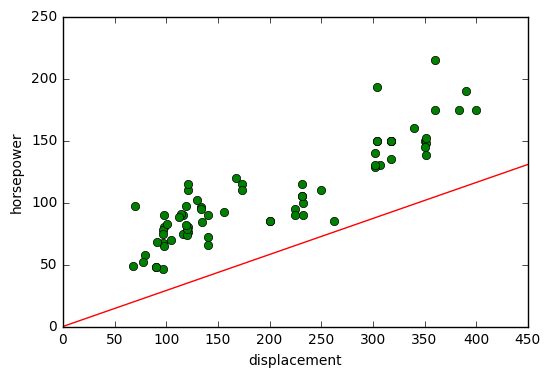

In [8]:
import matplotlib.pyplot as plt


x_model=[0, 450]
y_model = [linear_model.intercept, linear_model.intercept + 450 * linear_model.weights[0]]


plt.plot(x_model, y_model, color='red')

print x_model
plt.xlabel('displacement')
plt.ylabel('horsepower')

x_real = test_data.map(lambda v: float(v[2]))
y_real = test_data.map(lambda v: float(v[3]))


plt.plot (x_real.collect(), y_real.collect(), "go")
plt.show()

# Problem 2.

Vector lenght calculation for binary encoding

In [75]:
def get_mapping(rdd, idx):    
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap() 

data_ord = records.filter(lambda v: v[3]<>"NA" and v[0]<>"NA")\
.map(lambda v: (v[1],v[6],v[7],v[8],v[2],v[3],v[4],v[5],v[0]))

print data_ord.take(1)
mappings = [get_mapping(data_ord, i) for i in range(0,4)] 
cat_len = sum(map(len, mappings))
num_len = num_len = len(data_ord.first()[4:8]) 
total_len = num_len + cat_len 

print "Feature vector length for categorical features: %d" % cat_len 
print "Feature vector length for numerical features: %d" % num_len
print "Total feature vector length: %d" % total_len

[(u'8', u'70', u'1', u'chevrolet', u'307', u'130', u'3504', u'12', u'18')]
Feature vector length for categorical features: 59
Feature vector length for numerical features: 4
Total feature vector length: 63


In [76]:
def extract_features(record):    
    cat_vec = np.zeros(cat_len)    
    i = 0    
    step = 0    
    for field in record[0:4]:      
        m = mappings[i]       
        idx = m[field]       
        cat_vec[idx + step] = 1       
        i = i + 1       
        step = step + len(m)    
    num_vec = np.array([float(field) for field in record[4:8]])    
    return np.concatenate((cat_vec, num_vec)) 
 
def extract_label(record):     
    return float(record[8]) 

data_bin = data_ord.map(lambda r: LabeledPoint(extract_label(r),extract_features(r)))

print data_bin.take(1)


first_point = data_bin.first() 
print "Label: " + str(first_point.label) 
print "Linear Model feature vector:\n" + str(first_point.features) 
print "Linear Model feature vector length: " + str(len(first_point. features)) 

[LabeledPoint(18.0, [1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,307.0,130.0,3504.0,12.0])]
Label: 18.0
Linear Model feature vector:
[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,307.0,130.0,3504.0,12.0]
Linear Model feature vector length: 63


Regression model with 8 feature variables and one label variable

In [187]:
#from the binary encoded DDR, sample 20% for training and rest for test
records_ord_with_idx = data_bin.zipWithIndex().map(lambda (k, v): (v, k)) 
test_data_ord_idx = records_ord_with_idx.sample(False, 0.2, 42)
training_data_ord_idx = records_ord_with_idx.subtractByKey(test_data_ord_idx) 

test_data_ord_bin = test_data_ord_idx.map(lambda (idx, p) : p) 
training_data_ord_bin = training_data_ord_idx.map(lambda (idx, p) : p)

linear_model_bin = LinearRegressionWithSGD.train(training_data_ord_bin, iterations=200,step=0.000001, intercept=False)
print linear_model_bin


(weights=[-4.21008505334e-05,5.33311742477e-07,7.45910120355e-07,9.47592829671e-05,-4.9269245261e-06,1.41319213125e-06,2.8411482803e-06,-2.9034811825e-07,3.34579127888e-06,-1.07767545496e-05,-3.42232820761e-06,1.32074063019e-06,-2.90821773285e-06,1.65854784981e-05,1.76425234945e-05,1.29541462769e-05,4.42163777876e-06,5.88372002577e-06,-2.0617097041e-05,4.54574306275e-05,2.41703962308e-05,1.53683622298e-07,-2.42449018113e-06,1.89577044782e-06,3.66381074659e-06,1.95919773287e-07,-4.20583232877e-07,7.73583368314e-07,2.51203812411e-06,-1.35701611292e-06,-3.5340634894e-06,3.02179736914e-07,9.68014411037e-07,7.71622345131e-07,-2.42264177469e-06,-6.50318482397e-07,-2.98150849445e-06,1.04631755584e-05,6.9417435362e-07,-3.51798133598e-06,5.27432147954e-06,2.37624519327e-07,0.0,5.8632379819e-07,3.13626941682e-07,8.53350160274e-06,8.32965803335e-07,3.09078522754e-06,-2.18157505799e-06,1.58927098801e-06,8.59637932487e-07,1.14062830764e-05,4.53141310936e-07,-2.90169099133e-07,-3.57516592818e-07,-1.

In [104]:
true_vs_predicted_bin = test_data_ord_bin.map(lambda p: (p.label, linear_model_bin.predict(p.features)))
print str(true_vs_predicted_bin.take(5))

mse_bin = true_vs_predicted_bin.map(lambda (t, p): squared_error(t, p)).mean() 
mae_bin = true_vs_predicted_bin.map(lambda (t, p): abs_error(t, p)).mean() 


print "Mean Square Error (MSE): %f" %mse_bin
print "Mean Absolute Error (MAE): %f" %mae_bin

[(18.0, 23.115221913652338), (16.0, 23.187055163481137), (15.0, 25.663346046434), (28.0, 28.043510504530769), (14.0, 24.234786713495044)]
Mean Square Error (MSE): 150.737088
Mean Absolute Error (MAE): 10.257624


# Problem 3

Creater feature vectors for the decision tree

In [154]:
def get_mapping_dt(rdd, idx):    
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()  

#convert car string variable to numeric
print "Mapping of first categorical feature column: %s" % get_mapping(data_ord, 3) 


def extract_features_dt(record):    
    return np.array(map(float, record[0:7])) 

def extract_label_dt(record):     
    return float(record[7]) 
 
#removed car model from the feauture variables, I could manage to add the dictionary to the RDD
data_tree_no_car_type = data_ord.map(lambda v: (v[0],v[1],v[2],v[4],v[5],v[6],v[7],v[8]))


data_tree = data_tree_no_car_type.map(lambda r: LabeledPoint(extract_label_dt(r), extract_features_dt(r))) 

first_point_tree = data_tree.first() 
print "Decision Tree feature vector: " + str(first_point_tree.features) 
print "Decision Tree feature vector length: " + str(len(first_point_tree.features)) 

Mapping of first categorical feature column: {u'buick': 1, u'subaru': 2, u'vw': 3, u'chevroelt': 5, u'opel': 6, u'audi': 7, u'mercury': 8, u'chevrolet': 9, u'datsun': 35, u'capri': 10, u'amc': 15, u'dodge': 12, u'pontiac': 13, u'cadillac': 14, u'maxda': 11, u'honda': 16, u'vokswagen': 17, u'ford': 18, u'mazda': 19, u'toyouta': 20, u'hi': 21, u'bmw': 22, u'mercedes-benz': 23, u'volkswagen': 24, u'peugeot': 25, u'fiat': 26, u'saab': 31, u'oldsmobile': 34, u'renault': 28, u'nissan': 29, u'toyota': 30, u'volvo': 0, u'chevy': 32, u'plymouth': 33, u'chrysler': 27, u'citroen': 4, u'mercedes': 36, u'triumph': 37}
Decision Tree feature vector: [8.0,70.0,1.0,307.0,130.0,3504.0,12.0]
Decision Tree feature vector length: 7


In [167]:
from pyspark.mllib.tree import DecisionTree

#from the RDD sample 20% for training and rest for test
records_tree_with_idx = data_tree.zipWithIndex().map(lambda (k, v): (v, k)) 
test_tree_idx = records_tree_with_idx.sample(False, 0.2, 42)
training_tree_idx = records_tree_with_idx.subtractByKey(test_tree_idx) 

test_tree = test_tree_idx.map(lambda (idx, p) : p) 
training_tree = training_tree_idx.map(lambda (idx, p) : p)

model_tree = DecisionTree.trainRegressor(training_tree,{}) 

preds_tree = model_tree.predict(test_tree.map(lambda p: p.features)) 
actual_tree = test_tree.map(lambda p: p.label) 
true_vs_predicted_tree = actual_tree.zip(preds_tree) 

print "Decision Tree predictions: " + str(true_vs_predicted_tree.take(5)) 
print "Decision Tree depth: " + str(model_tree.depth()) 
print "Decision Tree number of nodes: " + str(model_tree.numNodes()) 


Decision Tree predictions: [(18.0, 15.25), (16.0, 15.25), (15.0, 21.5), (28.0, 21.5), (14.0, 15.25)]
Decision Tree depth: 5
Decision Tree number of nodes: 61


In [177]:
mse_tree = true_vs_predicted_tree.map(lambda (t, p): squared_error(t, p)).mean() 
mae_tree = true_vs_predicted_tree.map(lambda (t, p): abs_error(t, p)).mean() 


print "Mean Square Error(MSE):  Linear Regression %f" %mse_bin  + "| Decision Tree %f" %mse_tree

print "Mean Absolute Error (MAE):  Linear Regression %f" %mae_bin  + "| Decision Tree %f" %mae_tree

 

Mean Square Error(MSE):  Linear Regression 150.737088| Decision Tree 13.420670
Mean Absolute Error (MAE):  Linear Regression 10.257624| Decision Tree 2.684123


# Problem 4

Calculate the RMSL error for the first linear regression model calculated in Problem 1

In [188]:
import math
def squared_log_error(pred, actual):    
    return (np.log(pred + 1) - np.log(actual + 1))**2 

rmsle = np.sqrt(true_vs_predicted.map(lambda (t, p): squared_log_error(t,p)).mean()) 

print rmsle

0.715926436898


Now we recalculate the RMSLE using different parameters to feed the model. Using regularization L2

In [229]:
def evaluate(train, test, iterations, step, regParam,regType,intercept):
    model = LinearRegressionWithSGD.train(train,iterations,step,regParam=regParam, regType=regType, intercept=intercept)
    tp = test.map(lambda p: (p.label, model.predict(p.features)))
    rmsle = np.sqrt(tp.map(lambda (t, p): squared_log_error(t,p)).mean())
    return rmsle 

train_rmsle = training_data.filter(lambda v: v[3]<>"NA").map(lambda r: LabeledPoint(float(r[3]),np.array(r[2:3])))
test_rmsle = test_data.filter(lambda v: v[3]<>"NA").map(lambda r: LabeledPoint(float(r[3]),np.array(r[2:3])))
 
#number of iterations
params = [1, 5, 10, 20, 50, 100, 500, 1000, 2000, 3000]
metrics = [evaluate(train_rmsle, test_rmsle, param, 0.000001, 0.0, 'l2',False) for param in params]
print params
print metrics  #increase in  the number of iterations decreases the error



[1, 5, 10, 20, 50, 100, 500, 1000, 2000, 3000]
[2.9565523017728097, 2.0030457444244507, 1.6394250953478053, 1.3110754358133967, 0.93708363001884221, 0.71592643689771196, 0.71592643689771196, 0.71592643689771196, 0.71592643689771196, 0.71592643689771196]


Plot previous results

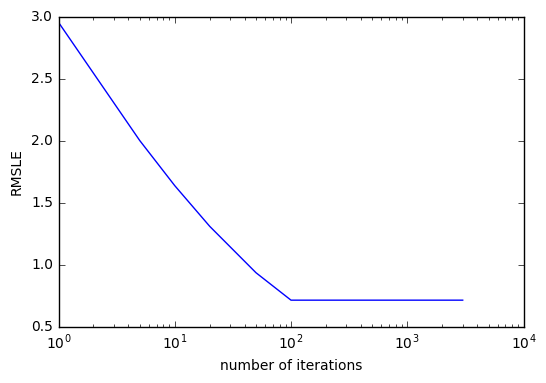

In [234]:
plt.plot(params, metrics)
plt.xscale('log')
plt.xlabel('number of iterations')
plt.ylabel('RMSLE')

It seems from the previous that the model reaches a point where increasing the number of iterations does not improve the model, since the error remains the same.

Next steps is to add the step value to tue equation as a parameter 

In [231]:
params_step = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
metrics_step = [evaluate(train_rmsle, test_rmsle, 100, param, 0.0, 'l2',False) for param in params_step]
print params_step
print metrics_step

[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0]
[3.6678256677324379, 0.71592643689771196, 0.31720391423713545, 0.31025992265910929, nan, nan, nan, nan]


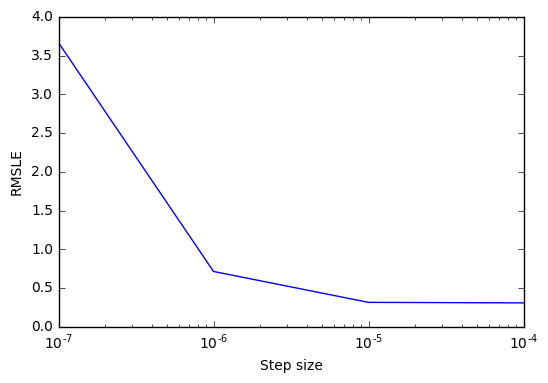

In [233]:
plt.plot(params_step, metrics_step)
plt.xscale('log')
plt.xlabel('Step size')
plt.ylabel('RMSLE')